In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from time import time
from sklearn.metrics import roc_auc_score
import networkx as nx
from scipy.io import mmread
import os

In [2]:
import BiMent

## Get Data

In [19]:
n_data = 2

ROOT = '/Users/tradergllc/rsi/datasets/congress/csv/test/dem113'
adj_mx = mmread(os.path.join(ROOT, 'data%d.mtx' % n_data)).toarray()
with open(os.path.join(ROOT, 'numPositivePairs%d.txt' % n_data), 'r') as f:
    N_PAIRS = int(f.read())

print N_PAIRS

1


## Weighted Correlation

### Generate Test Data

In [20]:
GT_POS_PAIRS = [(2*i, 2*i + 1) for i in range(N_PAIRS)]
print GT_POS_PAIRS

[(0, 1)]


### Baseline

In [21]:
phi = adj_mx.sum(axis=0) / adj_mx.shape[0]
# phi = x_train.sum(axis=0) / x_train.shape[0]
print phi[:20]

[0.         0.97333333 0.         0.61333333 0.89333333 0.89333333
 0.13333333 0.96       0.96       0.96       0.04       0.4
 0.94666667 0.94666667 0.93333333 0.92       0.90666667 0.92
 0.90666667 0.50666667]


In [22]:
# Ensure all p_i's are non-zero
adj_mx_nonzero = adj_mx.copy()
adj_mx_nonzero = adj_mx_nonzero[:, np.where(np.logical_and(phi > 0, phi < 1))[0]]

phi = adj_mx_nonzero.sum(axis=0) / adj_mx_nonzero.shape[0]
print phi[:20]

[0.97333333 0.61333333 0.89333333 0.89333333 0.13333333 0.96
 0.96       0.96       0.04       0.4        0.94666667 0.94666667
 0.93333333 0.92       0.90666667 0.92       0.90666667 0.50666667
 0.86666667 0.86666667]


In [23]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx_nonzero.shape[0]):
    for j in np.arange(i + 1, adj_mx_nonzero.shape[0]):
        X = adj_mx_nonzero[i]
        Y = adj_mx_nonzero[j]
        
        WC = (1.0/ phi.shape[0])* (X- phi)* (Y- phi)/ (phi*(1-phi))
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS or (j, i) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.139000 sec


In [24]:
WC_arr[WC_idx]

array([0.05568756])

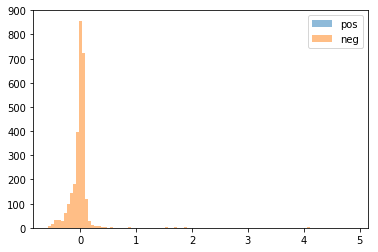

In [25]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [26]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.8240807498197549


### Estimate Phi using ERGM

In [27]:
# np.all(adj_mx == x_train[choice])

In [28]:
# fs = x_train.sum(axis=1)
# gs = x_train.sum(axis=0)
fs = adj_mx.sum(axis=1)
gs = adj_mx.sum(axis=0)
X, Y, X_bak, Y_bak = BiMent.solver(fs, gs, tolerance=1e-5, max_iter=10000)

counter=0, change=3.258421
counter=500, change=0.306176
counter=1000, change=0.314094
counter=1500, change=0.316560
counter=2000, change=0.317711
counter=2500, change=0.318354
counter=3000, change=0.318752
counter=3500, change=0.319015
counter=4000, change=0.319197
counter=4500, change=0.319327
counter=5000, change=0.319422
counter=5500, change=0.319491
counter=6000, change=0.319543
counter=6500, change=0.319581
counter=7000, change=0.319610
counter=7500, change=0.319631
counter=8000, change=0.319645
counter=8500, change=0.319655
counter=9000, change=0.319661
counter=9500, change=0.319665
Solver done in 10.0 seconds.


In [29]:
phi_all = X[:, None] * Y / (1 + X[:, None] * Y)
# phi_ia = X_bak[:, None] * Y_bak / (1 + X_bak[:, None] * Y_bak)
print phi_all.shape

(75, 1199)


In [30]:
phi_ia = phi_all #[choice]
print phi_ia.shape

(75, 1199)


In [31]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx.shape[0]):
    for j in np.arange(i + 1, adj_mx.shape[0]):
        X = adj_mx[i]
        Y = adj_mx[j]
        E_X = phi_ia[i]
        E_Y = phi_ia[j]
        
        WC = (1.0/ phi_ia.shape[1])* (X- E_X)* (Y- E_Y)/ (np.sqrt(E_X*E_Y*(1-E_X)*(1-E_Y)) + 1e-6)
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS or (j, i) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.109253 sec


In [32]:
WC_arr[WC_idx]

array([0.39187618])

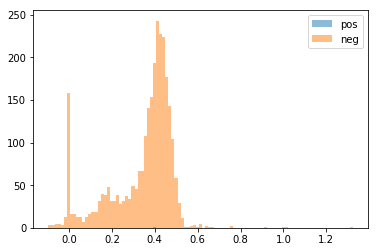

In [33]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [34]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.48341744772891126


### Analyze Graph Properties

In [33]:
non_zero_affil = np.sum(adj_mx, axis=0)
where_non_zero_affil = list(np.where(non_zero_affil > 0)[0])
print len(where_non_zero_affil)
print where_non_zero_affil

62
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 49, 69, 70, 72, 73, 75, 78, 79, 81, 82, 105, 113, 115, 123, 139, 168, 169, 176, 178, 182]


In [34]:
G = nx.Graph()
item_list = [('I'+ str(i)) for i in range(adj_mx.shape[0])]
affil_list = [('A'+ str(i)) for i in range(len(where_non_zero_affil))]
G.add_nodes_from(item_list, bipartite=0)
G.add_nodes_from(affil_list, bipartite=1)

In [35]:
where_i, where_a = np.where(adj_mx == 1)
edges = []
for j in range(where_i.shape[0]):
    I = item_list[where_i[j]]
    A = affil_list[where_non_zero_affil.index([where_a[j]])]
    edges.append((I, A))

In [36]:
G.add_edges_from(edges)

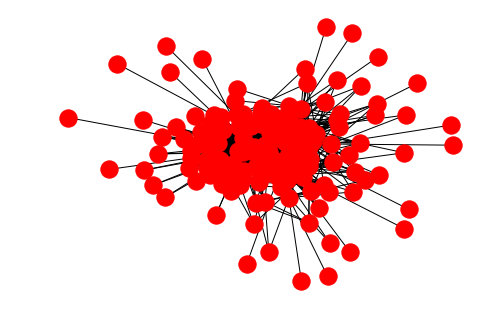

In [37]:
nx.draw(G)

In [38]:
print nx.info(G)

Name: 
Type: Graph
Number of nodes: 147
Number of edges: 933
Average degree:  12.6939


In [39]:
nx.number_connected_components(G)

1

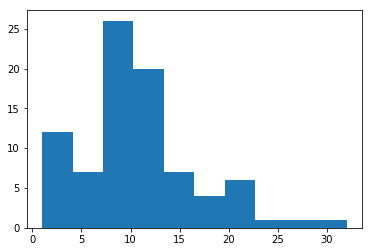

In [40]:
deg_hist = nx.degree_histogram(G)
# plt.bar(range(len(deg_hist)), deg_hist)
plt.hist(adj_mx_nonzero.sum(axis=1))
plt.show()

In [41]:
from networkx.algorithms import bipartite
X, Y = bipartite.sets(G)

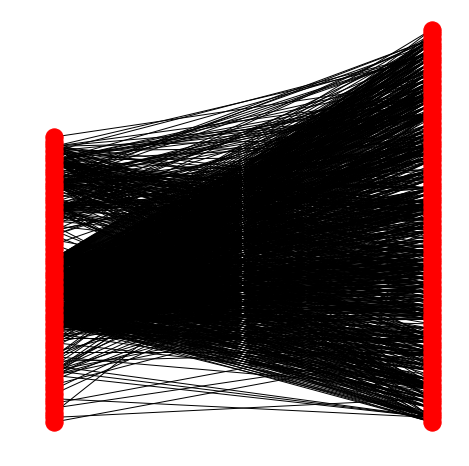

In [42]:
plt.figure(figsize=(6,6))
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G, pos=pos)
plt.show()